# Algorithme d'estimation de phase
Francis Blais (2151696) et Vincent Girouard (2152383)

12 novembre 2023
## Objectif de l'algorithme
L'algorithme d'estimation de phase est un algorithme assez particulier dans le sens que le problème qu'il essaie de résoudre est purement quantique***. On considère un opérateur unitaire inconnu $U$ et un état d'entrée $\ket{\psi}$ de $n$ qubits. Il nous est assuré que $\ket{\psi}$ est un état propre de $U$ tel que

$$ U\ket{\psi} = \lambda\ket{\psi}  $$

où $\lambda$ est la valeur propre associée à l'état $\ket{\psi}$. Comme $U$ est unitaire, $|\lambda|^2=1$ ce qui permet de simplifier le problème en décrivant complètement la valeur propre par une phase $\theta\in[0,1[$ comme suit : $\lambda = e^{i2\pi\theta}$. Comme son nom l'indique, l'algorithme d'estimation de phase a pour objectif d'approximer selon une précision voulue la valeur de $\theta$. On parle ici d'approximation, car la précision à laquelle il sera possible de connaitre $\theta$ dépendra du nombre de quibit de référence choisi. Cet algorithme diffère un peu d'autres algorithmes quantiques dans le sens qu'ici, l'entrée comprend un état quantique $\ket{\psi}$. De ce fait, cet algorithme est souvent utilisé en pair avec d'autres algorithmes plus complexes. C'est noramment une partie très importante de l'algorithme de Shor permettant de factoriser des entiers. 

## Description de l'algorithme
L'algorithme d'estimation de phase peut être séparé en plusieurs étapes clés: 
+ [Initialisation](#initialisation)
+ [Calcul](#calcul)
+ [Transformée de Fourier](#transformée-de-fourier)


### Initialisation
Comme mentionné à la section précédente, une particularité de l'algorithme d'estimation de phase est qu'un qubit $\psi$ est donné en entré. En plus du qubit d'entrée, l'algorithme d'estimation de 
phase utilise $m$ qubit de contrôle. La valeur de $m$ est arbitraire et influe sur la précision de l'approximation déesiréee. Plus la valeur de $m$ est élevée plus l'approximation sera bonne. L'état initial regroupe donc tous les qubits de contrôle et le qubit d'entrée $\psi$. L'étape d'initialisation est assez simple et consiste à appliquer une porte d'Hadamard sur tous les qubits de contrôle. Dénotons l'état initial $\ket{\pi_0} = \ket{\psi}\otimes\ket{0}_1\otimes...\otimes\ket{0}_m$ où les $\ket{0}_i$ représentent les $i$ qubits de contrôle.  Dénotons maintenant $\ket{\pi_1}$ l'état après avoir appliquer la porte Hadamard $H_m$ sur les $m$ qubits de contrôle

$$ \ket{\pi_0} \xrightarrow{H_m} \ket{\pi_1} = \ket{\psi}\otimes\frac{1}{\sqrt{2}}\big(\ket{0}_1 + \ket{1}_1\big)\otimes...\otimes\frac{1}{\sqrt{2}}\big(\ket{0}_m + \ket{1}_m\big) $$

### Calcul
Avant de poursuivre l'algorithme, il est imnportant de poser quelques définitions. Comme l'objectif est d'approximer $\theta$, l'approximation faite va être en binaire. Il est donc judicieux de définir $\theta$ avec un forme binaire comme suit $\theta = 0.\phi_1\phi_2...\phi_n$ où les $\phi_i\in{0,1}$. De ce fait, il est possible de déterminer l'effet d'appliquer plusieurs fois l'opérateur $U$ à l'état $\psi$. Prenons pour exemple 2 fois.

$$U^2\ket{\psi} = e^{i2\pi\cdot2(0.\phi_1\phi_2...\phi_n)} = e^{i2\pi(\phi_1.\phi_2...\phi_n)} = e^{i2\pi(0.\phi_2...\phi_n)} $$ 

Il est possible de voir ici qu'appliquer deux fois l'opérateur unitaire $U$ à son vecteur propre $\psi$ a pour effet de décaler la position du point (décimale en base 10) vers la droite. Cette propriété peut être généralisée pour plus que 2 itérations de $U$ où à chaque $2^i$ itérations, la position du point est décalée vers la droite. Par exemple, si $\theta$ peut être décrit avec $n$ bits, alors appliquer $2^n$ fois l'opérateur $U$ donnera

$$U^2\ket{\psi}=e^{i2\pi(\phi_n)}  $$

Plus de détails sur ces équations et pourquoi elles sont vraies seront donnés à la section [principe de fonctionnement](#principe-de-fonctionnement). À l'aide de ces propriétés, l'algorithme d'estimation de phase applique l'opérateur $U$ $2^(i-1)$ fois avec le ieme qubit étant un bit de contôle de telle sorte que $U$ est appliqué seulement si le ieme qubit de contrôle est dans l'état $\ket{1}$. Par exemple, on applique une fois $U$ avec le premier filtre de contrôle, deux fois $U$ avec le deuxième bit de contrôle, 4 fois $U$ avec le troisième bit de contrôle et ainsi de suite jusqu'au $m$ qubit de contrôle. Pour une meilleure visualisation, l'image ci-dessous illustre cette opération [1]. Dénotons $C(U)$ cette opération sur l'état $\ket{\pi_1}$ et $\ket{\pi_2}$ l'état après avoir appliquer $C(U)$. D'après les définitions précédentes, il peut s'écrire comme

$$\ket{\pi_1} \xrightarrow{C(U)} \ket{\pi_2} = \ket{\psi}\otimes\frac{1}{2^{m/2}}\big(\ket{0}_1 + e^{i2\pi(0.\phi_1\phi_2...\phi_m)}\ket{1}_1\big)\otimes...\otimes\big(\ket{0}_m + e^{i2\pi(\phi_m)}\ket{1}_m\big).$$

![Schema de C(U)](CU_schema.png)

### Transformée de Fourier
Après avoir obtenu les états précédents, il est difficile de tirer de l'information simplement en faisant une mesure des qubits de contrôles de $\pi_2$. C'est pourquoi, l'algorithme de changement de phase fait utilisation de la transformée de Fourier quantique (QFT). Cette transformée de Fourier est discrète et est appliqué à des états quantiques et plus spécifiquement des qubits. L'opérateur de transformée de Fourier de $N$ dimensions $QFT_N$ peut être décrit comme suit

$$ QFT_N = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}\sum_{y=0}^{N-1}e^{i\frac{2\pi}{N} xy}\ket{x}\bra{y}$$

Ce qui est intéressant est qu'appliquer la transformée de Fourier sur la base des états {$\ket{\phi_1}\otimes\ket{\phi_2}\otimes...\otimes\ket{\phi_m}$} donne 

$$ QFT_{2^m}\{\ket{\phi_1}\otimes\ket{\phi_2}\otimes...\otimes\ket{\phi_m}\} = \frac{1}{2^{m/2}}\big(\ket{0}_1 + e^{i2\pi(0.\phi_1\phi_2...\phi_m)}\ket{1}_1\big)\otimes...\otimes\big(\ket{0}_m + e^{i2\pi(\phi_n)}\ket{1}_m\big) $$

On remarque que cette forme est exactement la même que l'état des qubits de contrôle de $\pi_2$. Ainsi, pour pouvoir passer de l'état $\pi_2$ à un état dans la base {$\ket{\phi_1}\otimes\ket{\phi_2}\otimes...\otimes\ket{\phi_m}$}, il suffit d'appliquer l'opération inverse. Comme $QFT_N$ est un opérateur unitaire, alors il possède une inverse dénoté $QFT_N^{\dag}$ et appelé transformée de Fourier quantique inverse. Il est important de noter que l'opérateur de transformée de Fourier est assez complexe à implémenter dans un circuit quantique et dépasse le cadre de ce travail. On se contentera ici de plutôt étudier ces effets. Ensuite, il est possible d'appliquer cet opérateur inverse aux qubits de contrôle pour se retrouver alors exactement dans la base des $\ket{\phi_i}$. Une image de l'algorithme complet est illustrée ci-dessous pour une meilleure compréhesion [1]. L'état $\pi_3$ après la transformée de Fourier inverse sera alors 

$$\ket{\pi_2} \xrightarrow{QFT_{2^m}^{\dag}} \ket{\pi_2} = \ket{\psi}\otimes\ket{\phi_1}\otimes\ket{\phi_2}\otimes...\otimes\ket{\phi_m} $$

Ainsi, en faisant une mesure de tous les qubits, il sera possible de trouver les valeurs des $\phi_i$ ce qui donnera la valeur finale de $\theta$ sous forme binaire. Si $\theta$ peut s'écrire sous forme binaire avec $n$ bits et que $n<m$ ($m$ est le nombre de qubits de contrôle utilisés), alors $\theta$ sera parfaitement retrouvé sans erreurs. Si $n<m$, il est tout de même possible d'avoir une estimation de la valeur de $\theta$. C'est d'ailleurs pourquoi on dit que cet algorithme est appelé estimation d'erreur; il est rare d'avoir une estimation parfaite de $\theta$. Dans le cas où l'estimation n'est pas parfaite, alors la probabilité d'obtenir la meilleure estimation possible est d'environ ~40% et la probabilité d'obtenir la moins bonne estimation possible est de 0.25%. Ce qui est intéressant est que cet algorithme ne change pas l'état $\psi$, il est alors possible de le reproduire plusieurs fois. De cette manière et en faisant une étude statistique, il est possible d'augmenter grandement les pourcentages de meilleurs et moins bonnes approximations au coût de plus de temps de calcul. 

![Schéma complet de l'algorithme d'estimation de phase](SchemaComplet.png)

## Principe de fonctionnement

## Implémentation

In [2]:
# Importation des librairies

import numpy as np
from qutip import Qobj, dag, tensor, basis
from qutip_qip.circuit import QubitCircuit, CircuitSimulator
from qutip_qip.operations import Gate, Measurement
from qutip_qip.algorithms import qft
import matplotlib.pyplot as plt
import random

In [3]:
def compute_phase(bit_sequence):
    num = 0
    for bit_index in range(len(bit_sequence)):
        num += bit_sequence[bit_index]*2**(-bit_index-1)
    return num

0.69140625


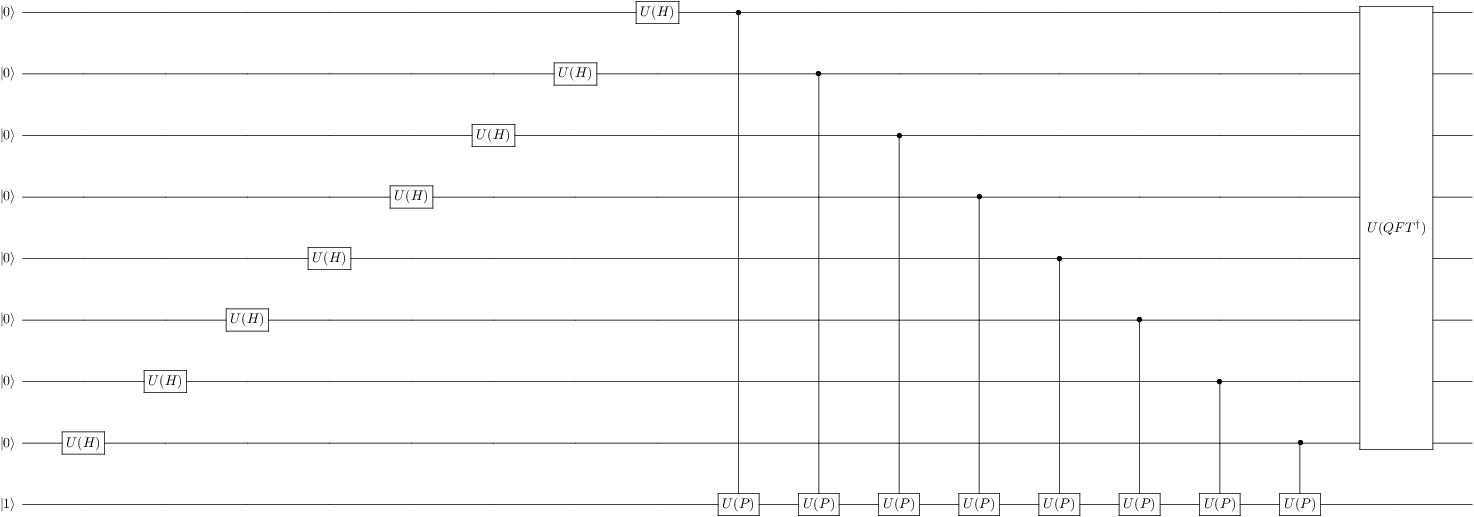

In [7]:
phase = 0.69      # Phase à estimer
N = 8               # Nombre de qubits

# Initialisation du circuit
input_label = ['1' if i == 0 else '0' for i in range(N+1)]    
circuit = QubitCircuit(N=N+1, input_states=input_label)           

# Ajout des portes de Hadamard pour chaque qubit
H_gates = [Gate("SNOT", targets=i+1, arg_label='H') for i in range(N)]     
circuit.add_gates(H_gates)

# Ajout de l'opérateur de phase
cphase_gates = [Gate("CPHASE", targets=0, controls=N-i, arg_value=2*np.pi*phase*2**i, arg_label='P') for i in range(N)]
circuit.add_gates(cphase_gates)

# Ajout de l'opérateur de QFT inverse
qft_matrix = qft(N).dag()
circuit.user_gates = {"INV_QFT": qft_matrix}
circuit.add_gate("INV_QFT", targets=[i+1 for i in range(N)], arg_label="QFT^{\dag}")

# État initial du système
initial_state = tensor([basis(2,1) if i == 0 else basis(2,0) for i in range(N+1)])
result = circuit.run(state=initial_state)

# Mesures des qubits à la sortie
measure_dict = {"m%d" % (i+1) : i for i in range(N)}
for values, keys in enumerate(measure_dict):
    measure_dict[keys] = Measurement(name=keys, targets=(N-values)).measurement_comp_basis(result)[1]

# Lecture de la phase
bit_output_sequence = []
for values in measure_dict.values():
    bit_output_sequence.append(random.choices([0, 1], weights=values, k=1)[0])
print(compute_phase(bit_output_sequence[::-1]))

circuit.png